# EDA on Condemned and Dead-End Properties Dataset

**Collected Data From [Here](https://data.wprdc.org/dataset/condemned-properties/resource/0a963f26-eb4b-4325-bbbc-3ddf6a871410)**

### **Data Dictionary**
- **reserved__id:** (no description)
- **parcel_id:** The alphanumeric identifier for the Allegheny County parcel of land corresponding to the condemned property.
- **address:** The street address for the condemned property. In some cases the value is “No primary address specified.” In most of those cases, the corresponding record in the Allegheny County Property Assessments table has a house number of zero—meaning the parcel no longer exists (e.g., parcels were merged or split).
- **owner:** The name of the person or entity who owns the condemned property.
- **property_type:** Indicates whether the property is just condemned (“Condemned Property”) or one where the owner could not be contacted (“Dead-End Property”).
- **date:** The date that the property received its classification (e.g., “Condemned”).
- **latest_inspection_result:** The pass/fail result that the property received in its last inspection.
- **latest_inspection_score:** The numerical score from the last inspection. A value of 0 indicates the property passed; higher integers indicate greater severity of failure.
- **inspection_status:** Either “Active” or “Inactive,” indicating whether the property is under ongoing investigation.



### **Goal**
**Fix the notes for the dataset first**
1. Create solution for the duplicate #'s of **parcel_id**
- so no removing duplicates in the data cleaning stage

2. Correct the numerical range of the **latest_inspection_score**
- currently 0-62
- fix to 1-4 --> the information of the Inspection Score is defined in 1-4 range already [here](https://engage.pittsburghpa.gov/pli-demolition-engagement)

## **I. Data Exploration**

In [1]:
# importing libraries
import pandas as pd               # data preprocessing
import numpy as np                # to work with #'s & arrays
import matplotlib.pyplot as plt   # more for graphing/visualizations

In [2]:
# bring in the file
deadend = "deadend.csv"            # csv for condemned + dead-end properties
deadend_df = pd.read_csv(deadend)
deadend_df.head(5)                 # sanity check - first 5

,_id,reserved__id,parcel_id,address,owner,property_type,date,latest_inspection_result,latest_inspection_score,inspection_status
0,330265,NaN,0081A00132000000,No primary address specified,MCCOY MARK JOEL & NICOLE HELENA (W),Condemned Property,2020-05-19T00:00:00,Fail,9.0,Inactive
1,330266,NaN,0174L00014000000,No primary address specified,BATTLE RAYNA,Condemned Property,2020-05-19T00:00:00,Fail,15.0,Inactive
2,330267,NaN,0175C00159000000,No primary address specified,WHEATON RALEIGH PIERRE,Condemned Property,2020-05-20T00:00:00,Fail,43.0,Inactive
3,330268,NaN,0049N00268000000,"321 37TH ST, Pittsburgh, 15201",NaN,Condemned Property,2020-05-21T00:00:00,Fail,21.0,Inactive
4,330269,NaN,0050M00310000000,"5452 BROAD ST, Pittsburgh, 15206",MONROE BRIAN,Condemned Property,2020-05-28T00:00:00,Fail,12.0,Inactive


In [3]:
deadend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       4346 non-null   int64  
 1   reserved__id              0 non-null      float64
 2   parcel_id                 4346 non-null   object 
 3   address                   4328 non-null   object 
 4   owner                     3658 non-null   object 
 5   property_type             4346 non-null   object 
 6   date                      4346 non-null   object 
 7   latest_inspection_result  3859 non-null   object 
 8   latest_inspection_score   3788 non-null   float64
 9   inspection_status         4344 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 339.7+ KB


### I.I Dropping Null Entries

In [4]:
print(deadend_df.isnull().sum())    # number of Null entries

_id                            0
reserved__id                4346
parcel_id                      0
address                       18
owner                        688
property_type                  0
date                           0
latest_inspection_result     487
latest_inspection_score      558
inspection_status              2
dtype: int64


**Note:**
- all *reserved_id* is Null
- 18 addresses is missing
- 688 owners are missing
- 487 latest inspection result is missing
- 558 latest inspection score is missing
- 2 inspection status is missing

First thing I'll try is removing all Null & checking the remaining # of entries.

In [5]:
# dropping reserved id - ALL Null values
deadend_df = deadend_df.drop(["reserved__id"], axis = 1)

# removing null
deadend_df.dropna(inplace = True)             # drop null in original df
deadend_df.info()                             # check the cleaned df

<class 'pandas.core.frame.DataFrame'>
Index: 3190 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       3190 non-null   int64  
 1   parcel_id                 3190 non-null   object 
 2   address                   3190 non-null   object 
 3   owner                     3190 non-null   object 
 4   property_type             3190 non-null   object 
 5   date                      3190 non-null   object 
 6   latest_inspection_result  3190 non-null   object 
 7   latest_inspection_score   3190 non-null   float64
 8   inspection_status         3190 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 249.2+ KB


### I.II Convert Date-Time to Date (YYYY-MM-DD) and Time Separately

In [6]:
# split the date into 2 features (date, time)
deadend_df[['new_date', 'time']] = (deadend_df['date'].str.split('T', expand = True))

# convert into proper types of date/time
deadend_df['new_date'] = pd.to_datetime(deadend_df['new_date']).dt.date
deadend_df['time'] = pd.to_datetime(deadend_df['time']).dt.time

# verify
print(deadend_df[['date','new_date','time']].head())

                  date    new_date      time
0  2020-05-19T00:00:00  2020-05-19  00:00:00
1  2020-05-19T00:00:00  2020-05-19  00:00:00
2  2020-05-20T00:00:00  2020-05-20  00:00:00
4  2020-05-28T00:00:00  2020-05-28  00:00:00
5  2020-05-29T00:00:00  2020-05-29  00:00:00


## **II. Explore Duplicate Parcel Rows**


**What Needs to be Fixed:**

Currently, some parcel_id values appear in multiple records, leading to the same property appearing multiple times, with different values for fields like latest_inspection_score . This will be fixed soon.


In [7]:
# get the counts of the parcel_id's
parcelid_count = deadend_df['parcel_id'].value_counts()

# filter to those with more than 1 entries with same parcel ID
duplicate_pid = parcelid_count[parcelid_count > 1].index.tolist()     # convert into a list

# print the number of duplicate parcel ids + how many there are
print(f"{duplicate_pid}\n{len(duplicate_pid)}")

['0174P00156000000', '0026R00174000000', '0013M00301000000', '0045B00056000000', '0173J00229000000', '0022K00391000000', '0050L00156000000', '0010G00213000000', '0024E00204000000', '0021E00088000000', '0055P00170000000', '0046G00031000000', '0055P00192000000', '0026K00260000000', '0023G00041000000', '0076N00283000000', '0057C00084000000', '0019D00167000000', '0032H00015000000', '0014R00059000000', '0015G00169000000', '0014F00357000000', '0022H00105000000', '0047N00303000000', '0174K00117000001', '0046A00044000000', '0041D00038000000', '0045N00181000000', '0172N00060000000', '0010G00233000000', '0047N00230000000', '0022E00280000000', '0045B00227000000', '0010K00149000C00', '0023H00275000000', '0015G00202000000', '0033B00338000000', '0173C00059000000', '0015R00157000000', '0022F00063000A00', '0077P00171000000', '0024K00003000000', '0087K00274000000', '0060B00087000000', '0014P00093000000', '0231L00240000000', '0033K00135000000', '0033B00226000000', '0124S00044000000', '0075S00180000000',

### II.I Normalize the Inspection Scores to a 1-4 Range then Compare for the Duplicate Parcel Id's


Score currently is in a 0-62 scale. If we want to convert it into a 1-4 scale, we have to divide it into groups:

1. 0 - 16
2. 16 - 32
3. 32 - 47
4. 47 - 62

Since 62/4 is not a whole number, divided it to a (16, 16, 15, 15) structure.


In [8]:
# bins for separation
bins = [0, 16, 32, 47, 63]                  # 63 since not inclusive

# corresponding new labels
labels = [1, 2, 3, 4]

# splitting the scores from df
deadend_df['score'] = pd.cut(
    deadend_df['latest_inspection_score'],  # take score (0-62)
    bins = bins,                            # interval gets corresponding label of (1-4)
    labels = labels,
    include_lowest = True                   # makes inclusive to lowest value
).astype(int)                               # converted into int

# we remove the old score feature
# deadend_df = deadend_df.drop(['latest_inspection_score'], axis = 1)

# check distribution
print(deadend_df['score'].value_counts().sort_index())

score
1    3138
2      25
3      24
4       3
Name: count, dtype: int64


In [9]:
# do we still have different scorings for the same parcel id's?
score_counts = deadend_df.groupby('parcel_id')['score'].nunique()

# only filter for those with more than one score
diff_score_ids = score_counts[score_counts > 1].index.tolist()

# show how many + which ones
print(f"{len(diff_score_ids)}\n{diff_score_ids}")

9
['0010N00307000000', '0014F00067000000', '0015G00098000000', '0015M00220000000', '0022F00119000000', '0043S00018000000', '0075M00337000000', '0094N00037000000', '0174K00324000000']


After normalizing the scoring system, we now only have 9 parcel ID's with differing scores.

### II.II Fix the remaining duplicate Parcel ID's



In [10]:
# filter the new list of different score parcel_id's
filtered = deadend_df[    # filtered is the df with 9 dup id's
    deadend_df['parcel_id'].isin(diff_score_ids)
].sort_values(['parcel_id', 'date'])

# print the individual duplicate parcel id with their latest score, new score, date
for pid, row in filtered.groupby('parcel_id'):    # row -> corresponding rows
    # header per group
    print(f"Parcel ID: {pid}")
    # only columns necessary in the row
    print(row[['parcel_id','new_date', 'time', 'latest_inspection_score','score']].to_string(index=False))
    print()   # blank line


Parcel ID: 0010N00307000000
       parcel_id   new_date     time  latest_inspection_score  score
0010N00307000000 2020-08-27 00:00:00                     32.0      2
0010N00307000000 2021-03-29 00:00:00                      0.0      1

Parcel ID: 0014F00067000000
       parcel_id   new_date     time  latest_inspection_score  score
0014F00067000000 2020-07-15 00:00:00                     12.0      1
0014F00067000000 2020-12-23 00:00:00                     36.0      3

Parcel ID: 0015G00098000000
       parcel_id   new_date     time  latest_inspection_score  score
0015G00098000000 2020-06-11 00:00:00                     15.0      1
0015G00098000000 2020-11-19 00:00:00                     40.0      3

Parcel ID: 0015M00220000000
       parcel_id   new_date     time  latest_inspection_score  score
0015M00220000000 2020-06-25 00:00:00                      2.0      1
0015M00220000000 2020-11-19 00:00:00                     17.0      2

Parcel ID: 0022F00119000000
       parcel_id   new_date 

We can see that the latest_inspection scores vary a lot in some ID's (EX: 0010N00307000000) and some not much (EX: 0022F00119000000)

- we will choose the latest (closest date to today's date 06/12/2025) to determine the new score to get rid of duplicates
- if the time is the same for the same date for different inspection scores, choose the higher score

In [11]:
# sort by parcel id, date, time, then the score to compare
sorted_df = filtered.sort_values(
    ['parcel_id', 'new_date', 'time', 'score'],
    ascending=[True, True, True, True]
)

# choose the latest scores (or the highest if date + time is the same)
latest_scores = sorted_df.drop_duplicates(subset='parcel_id', keep='last').reset_index(drop=True)

'''this should not have duplicates anymore'''
# repeat function
for pid, row in latest_scores.groupby('parcel_id'):
    print(f"Parcel ID: {pid}")
    print(row[['parcel_id','new_date', 'time','latest_inspection_score','score']].to_string(index=False))
    print()


Parcel ID: 0010N00307000000
       parcel_id   new_date     time  latest_inspection_score  score
0010N00307000000 2021-03-29 00:00:00                      0.0      1

Parcel ID: 0014F00067000000
       parcel_id   new_date     time  latest_inspection_score  score
0014F00067000000 2020-12-23 00:00:00                     36.0      3

Parcel ID: 0015G00098000000
       parcel_id   new_date     time  latest_inspection_score  score
0015G00098000000 2020-11-19 00:00:00                     40.0      3

Parcel ID: 0015M00220000000
       parcel_id   new_date     time  latest_inspection_score  score
0015M00220000000 2020-11-19 00:00:00                     17.0      2

Parcel ID: 0022F00119000000
       parcel_id   new_date     time  latest_inspection_score  score
0022F00119000000 2020-09-10 00:00:00                     49.0      4

Parcel ID: 0043S00018000000
       parcel_id   new_date     time  latest_inspection_score  score
0043S00018000000 2022-07-27 00:00:00                      0.0      1

### II.III Remove the existing duplicate Parcel ID's from Dataframe --> add the new fixed PID's

get rid of the 9 duplicate rows

In [12]:
# new copy of original df
cleaned_deadend_df = deadend_df.copy()

# for each parcel id in list of  pids with diff scores
for pid in diff_score_ids:
    # remove the duplicate pid rows
    cleaned_deadend_df = cleaned_deadend_df[cleaned_deadend_df['parcel_id'] != pid]

# add the cleaned pids back to the df
cleaned_deadend_df = pd.concat([cleaned_deadend_df, latest_scores], ignore_index=True)

# drop column : "latest_inspection_score"
cleaned_deadend_df = cleaned_deadend_df.drop(
    columns=['latest_inspection_score', 'date']
)

get rid of the rows with the same new scores to just one entry each

In [13]:
# collapse any remaining exact dupes on parcel_id + score
cleaned_deadend_df = cleaned_deadend_df.drop_duplicates(
    subset=['parcel_id', 'score'],
    keep='last'   # first or last - doesn't matter bc the values are the same for all dup pid's
).reset_index(drop=True)

In [14]:
# any duplicates? - should be no
dup_count = cleaned_deadend_df['parcel_id'].duplicated().sum()
print(dup_count, '\n')

print(cleaned_deadend_df.info())  # check

0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   _id                       2802 non-null   int64 
 1   parcel_id                 2802 non-null   object
 2   address                   2802 non-null   object
 3   owner                     2802 non-null   object
 4   property_type             2802 non-null   object
 5   latest_inspection_result  2802 non-null   object
 6   inspection_status         2802 non-null   object
 7   new_date                  2802 non-null   object
 8   time                      2802 non-null   object
 9   score                     2802 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 219.0+ KB
None


## **III. Explore CLEANED Data**

In [15]:
# written details of cleaned df
for col in cleaned_deadend_df.columns:
    print(f"--- {col} ---")
    print(cleaned_deadend_df[col].value_counts(dropna=False))
    print()

--- _id ---
_id
334086    1
330267    1
334601    1
334600    1
334599    1
         ..
330279    1
330278    1
330277    1
330273    1
330271    1
Name: count, Length: 2802, dtype: int64

--- parcel_id ---
parcel_id
0174K00324000000    1
0175C00159000000    1
0016P00209000000    1
0173P00074000000    1
0049J00282000000    1
                   ..
0083J00054000000    1
0083J00053000000    1
0050M00242000000    1
0050J00075000000    1
0124K00202000000    1
Name: count, Length: 2802, dtype: int64

--- address ---
address
No primary address specified             818
2428 ARLINGTON AVE, Pittsburgh, 15210      2
632 LINCOLN AVE, Pittsburgh, 15206         1
611 LINCOLN AVE, Pittsburgh, 15206         1
867 LILLIAN ST, Pittsburgh, 15210          1
                                        ... 
339 SYLVANIA AVE, Pittsburgh, 15210        1
1012 RIDGE AVE, Pittsburgh, 15233          1
18 RIDENOUR AVE, Pittsburgh, 15205         1
317 RENOVA ST, Pittsburgh, 15207           1
835 VISTA ST, Pittsburgh, 

One address has 2 entries:

In [16]:
# target address
address = "2428 ARLINGTON AVE, Pittsburgh, 15210"

# filter rows with specific address
row = cleaned_deadend_df[cleaned_deadend_df['address'] == address]

# display it
print(row)

         _id         parcel_id                                address  \
1403  332830  0013L00213000000  2428 ARLINGTON AVE, Pittsburgh, 15210   
1518  332991  0013L00213000001  2428 ARLINGTON AVE, Pittsburgh, 15210   

                        owner       property_type latest_inspection_result  \
1403  SMITHFIELD HOLDINGS INC  Condemned Property                     Fail   
1518  SMITHFIELD HOLDINGS INC  Condemned Property                     Fail   

     inspection_status    new_date      time  score  
1403            Active  2021-09-09  00:00:00      1  
1518            Active  2023-06-15  00:00:00      1  


Owner, property type, inspection result, inspection status, and score are the same. We will remove the older date entry.

In [17]:
# drop specific row
cleaned_deadend_df = cleaned_deadend_df.drop(index=1403).reset_index(drop=True)

# recheck the data with specific address
print(row)

         _id         parcel_id                                address  \
1517  332991  0013L00213000001  2428 ARLINGTON AVE, Pittsburgh, 15210   

                        owner       property_type latest_inspection_result  \
1517  SMITHFIELD HOLDINGS INC  Condemned Property                     Fail   

     inspection_status    new_date      time  score  
1517            Active  2023-06-15  00:00:00      1  


In [18]:
# recheck the full data
for col in cleaned_deadend_df.columns:
    print(f"--- {col} ---")
    print(cleaned_deadend_df[col].value_counts(dropna=False))
    print()

--- _id ---
_id
334086    1
334601    1
334600    1
334599    1
334598    1
         ..
330278    1
330277    1
330273    1
330271    1
330269    1
Name: count, Length: 2801, dtype: int64

--- parcel_id ---
parcel_id
0174K00324000000    1
0016P00209000000    1
0173P00074000000    1
0049J00282000000    1
0014P00102000000    1
                   ..
0083J00053000000    1
0050M00242000000    1
0050J00075000000    1
0124K00202000000    1
0050M00310000000    1
Name: count, Length: 2801, dtype: int64

--- address ---
address
No primary address specified           818
1100 LINCOLN AVE, Pittsburgh, 15206      1
632 LINCOLN AVE, Pittsburgh, 15206       1
611 LINCOLN AVE, Pittsburgh, 15206       1
867 LILLIAN ST, Pittsburgh, 15210        1
                                      ... 
339 SYLVANIA AVE, Pittsburgh, 15210      1
1012 RIDGE AVE, Pittsburgh, 15233        1
18 RIDENOUR AVE, Pittsburgh, 15205       1
317 RENOVA ST, Pittsburgh, 15207         1
835 VISTA ST, Pittsburgh, 15212          1
Nam

## **IV. Data Visualization of EACH Feature - Condemned Properties**

In [30]:
# creating condemned property df
condemned_prop_df = cleaned_deadend_df[(cleaned_deadend_df['property_type'] == 'Condemned Property')]
condemned_prop_df.shape

(2218, 10)

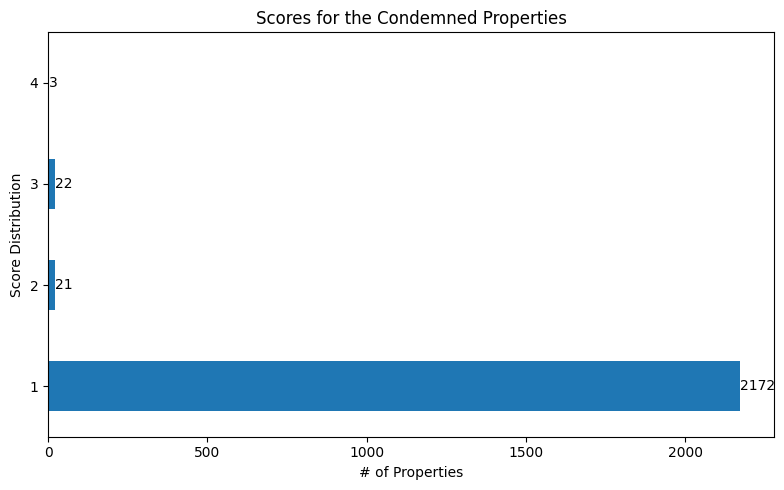

In [32]:
'''scores for condemned'''

# counts of condemned properties in each score label
condemned_score_counts = condemned_prop_df['score'].value_counts().sort_index()

# 2) plot horizontal bars and capture the Axes
condemned_score_plot = condemned_score_counts.plot.barh(figsize=(8, 5))

# 3) annotate each bar with its count
condemned_score_plot.bar_label(condemned_score_plot.containers[0])

# 4) titles and labels
plt.title('Scores for the Condemned Properties')
plt.xlabel('# of Properties')
plt.ylabel('Score Distribution')

plt.tight_layout()
plt.show()

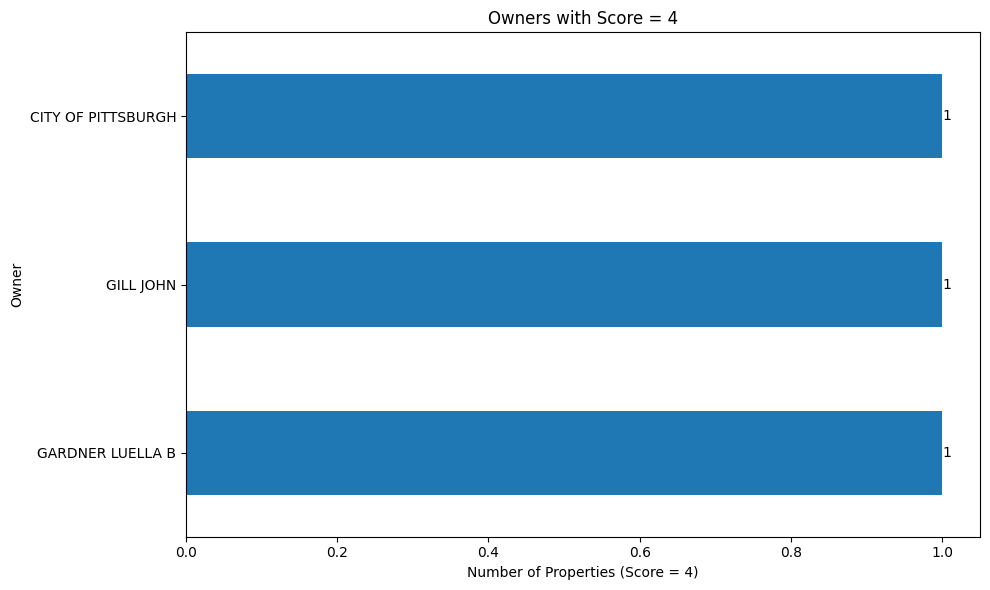

In [39]:
'''owners for the score 4 properties'''
# records with score = 4
score4 = condemned_prop_df[condemned_prop_df['score'] == 4]

# count occurrences per owner
owner_counts = score4['owner'].value_counts()

# horizontal bar chart
score4_owners = owner_counts.plot(kind='barh', figsize=(10, 6))
score4_owners.bar_label(score4_owners.containers[0])

# labels and title
plt.title('Owners with Score = 4')
plt.xlabel('Number of Properties (Score = 4)')
plt.ylabel('Owner')
plt.tight_layout()
plt.show()

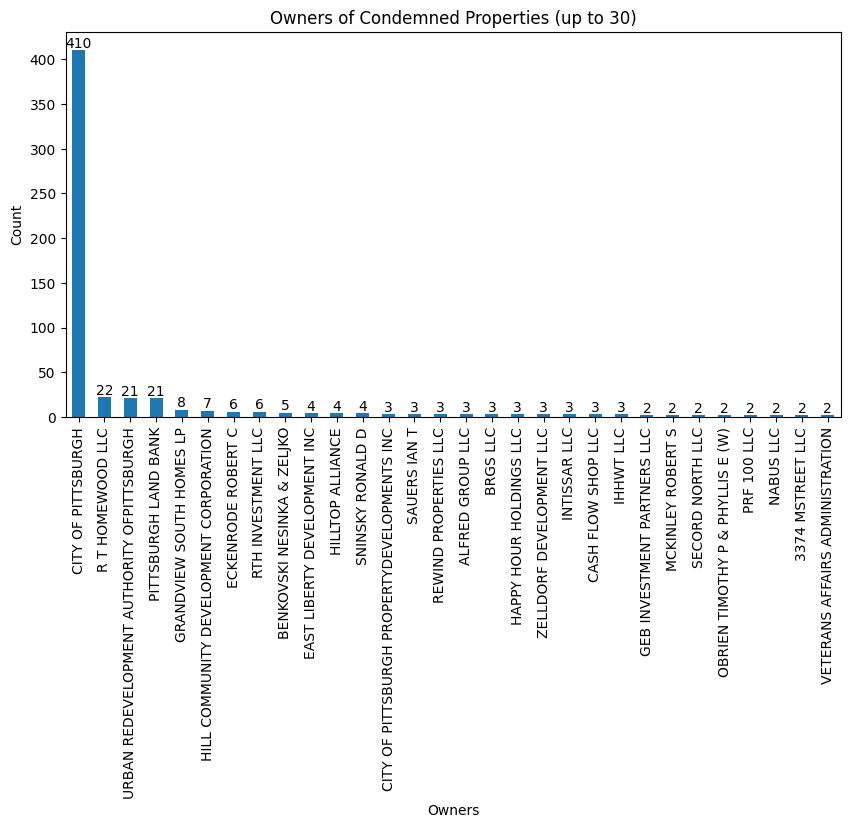

In [36]:
'''owner for condemned'''

# owner counts
owner_condemned_counts = condemned_prop_df['owner'].value_counts().nlargest(30)

# plot and label bars
owner_condemned_graph = owner_condemned_counts.plot(kind='bar', figsize=(10,5))
owner_condemned_graph.bar_label(owner_condemned_graph.containers[0])    # add the count labels

# design / details
plt.title('Owners of Condemned Properties (up to 30)')
plt.xlabel("Owners")
plt.ylabel('Count')
plt.show()

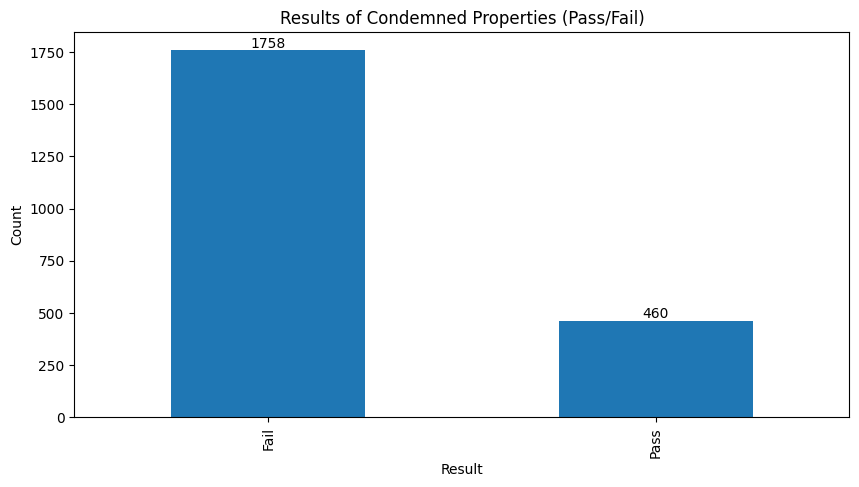

In [44]:
'''pass/fail for condemned'''

# pass/fail
result_condemned_counts = condemned_prop_df['latest_inspection_result'].value_counts()

# plot and label bars
result_condemned_graph = result_condemned_counts.plot(kind='bar', figsize=(10,5))
result_condemned_graph.bar_label(result_condemned_graph.containers[0])    # add count labels

# design / details
plt.title('Results of Condemned Properties (Pass/Fail)')
plt.xlabel("Result")
plt.ylabel('Count')
plt.show()

79.3% of Condemned Properties Fail Inspection.

## **V. Data Visualization of EACH Feature - Dead-End Properties**

In [28]:
# creating deadend property df
deadend_prop_df = cleaned_deadend_df[(cleaned_deadend_df['property_type'] == 'Dead End Property')]
deadend_prop_df.shape

(583, 10)

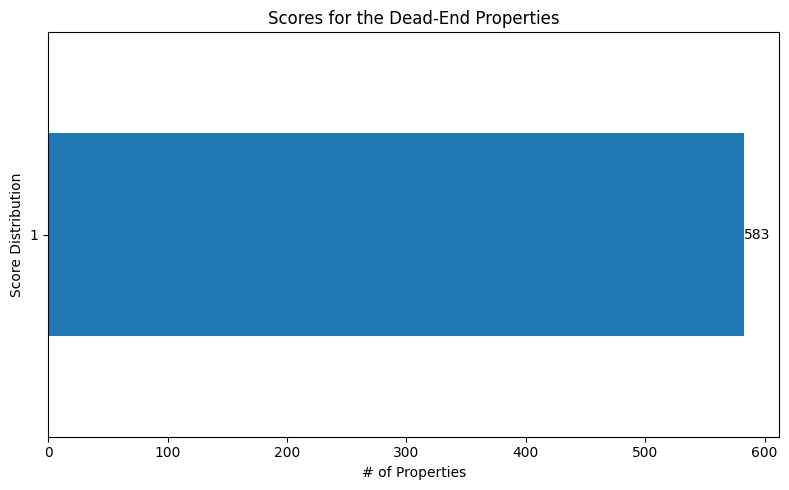

In [33]:
'''scores for deadend'''

# counts of condemned properties in each score label
deadend_score_counts = deadend_prop_df['score'].value_counts().sort_index()

# 2) plot horizontal bars and capture the Axes
deadend_score_plot = deadend_score_counts.plot.barh(figsize=(8, 5))

# 3) annotate each bar with its count
deadend_score_plot.bar_label(deadend_score_plot.containers[0])

# 4) titles and labels
plt.title('Scores for the Dead-End Properties')
plt.xlabel('# of Properties')
plt.ylabel('Score Distribution')

plt.tight_layout()
plt.show()

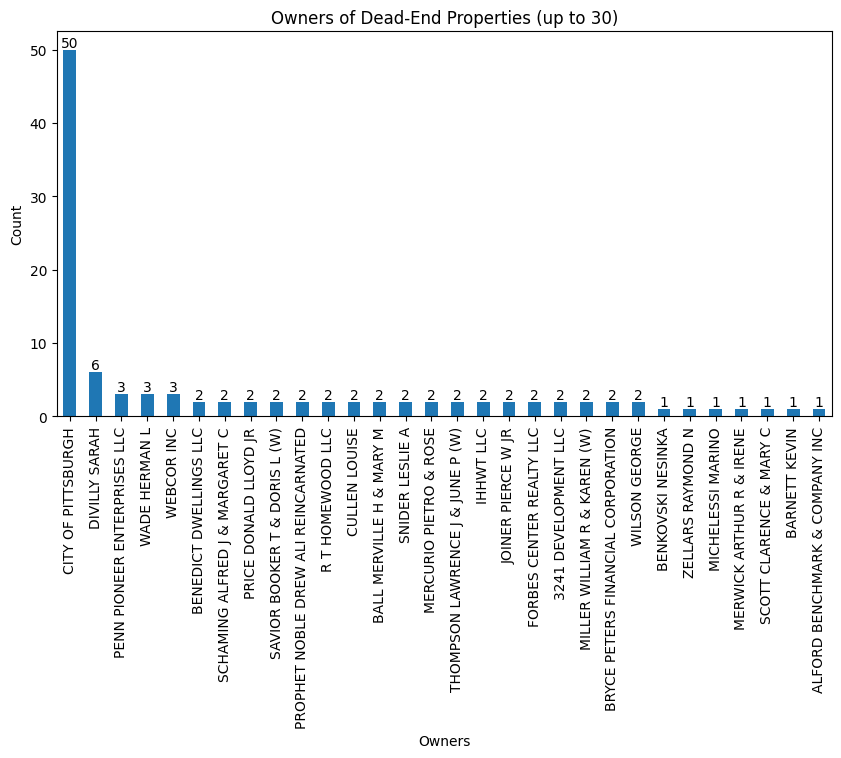

In [37]:
'''owner for condemned'''

# owner counts
owner_deadend_counts = deadend_prop_df['owner'].value_counts().nlargest(30)

# plot and label bars
owner_deadend_graph = owner_deadend_counts.plot(kind='bar', figsize=(10,5))
owner_deadend_graph.bar_label(owner_deadend_graph.containers[0])    # add the count labels

# design / details
plt.title('Owners of Dead-End Properties (up to 30)')
plt.xlabel("Owners")
plt.ylabel('Count')
plt.show()

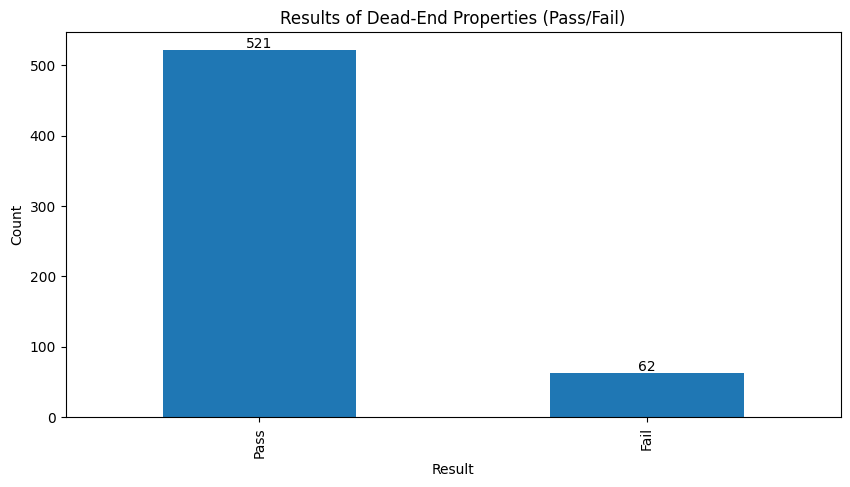

In [43]:
'''pass/fail for deadend'''

# pass/fail
result_deadend_counts = deadend_prop_df['latest_inspection_result'].value_counts()

# plot and label bars
result_deadend_graph = result_deadend_counts.plot(kind='bar', figsize=(10,5))
result_deadend_graph.bar_label(result_deadend_graph.containers[0])    # add count labels

# design / details
plt.title('Results of Dead-End Properties (Pass/Fail)')
plt.xlabel("Result")
plt.ylabel('Count')
plt.show()

10.6% of Dead-End Properties Fail Inspection.

### V.I latest_inspection_score (0-62) to 1-4 score groups

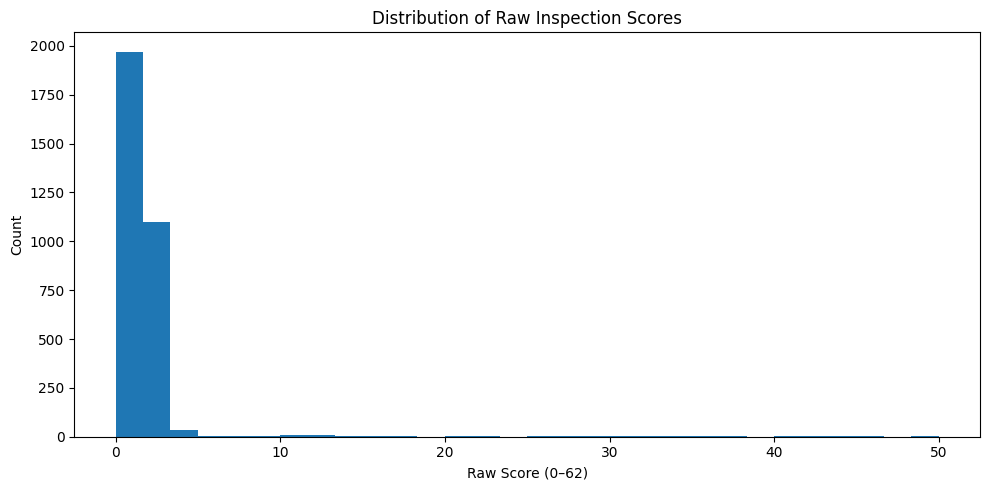

In [50]:
# defining the graph dimensions
plt.figure(figsize=(10,5))

# getting old scores
deadend_df['latest_inspection_score'].plot.hist(bins=30)

# details of graph
plt.title('Distribution of Inspection Scores')
plt.xlabel('Raw Score (0–62)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

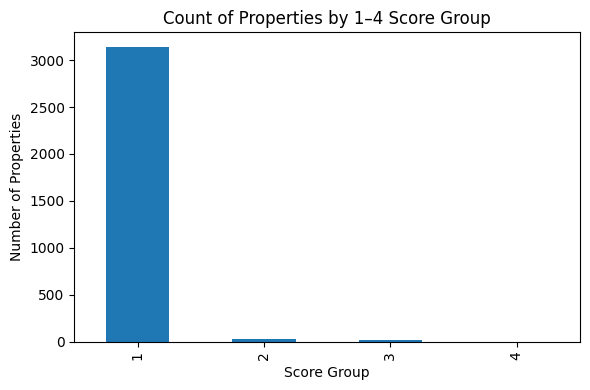

In [41]:
# defining the graph dimensions
plt.figure(figsize=(10,5))

# the new score
cleaned_deadend_df['score'].value_counts().sort_index().plot(kind='bar')

# details of graph
plt.title('Count of Properties by 1–4 Score Group')
plt.xlabel('Score Group')
plt.ylabel('Number of Properties')
plt.tight_layout()
plt.show()

### V.II Time Series of Inspection Counts by Month

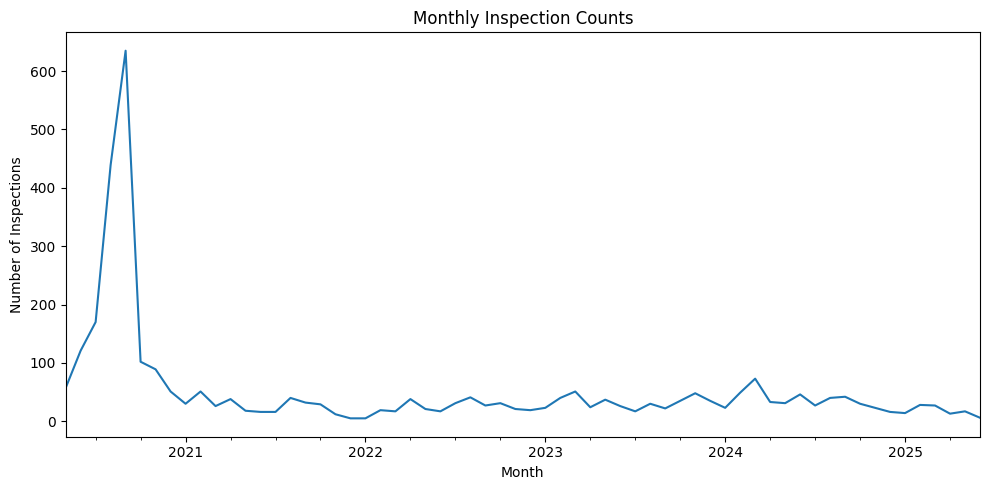

In [54]:
# convert date to datetime64 once:
deadend_df['new_date'] = pd.to_datetime(deadend_df['new_date'])

# build monthly counts in one line
monthly_counts = (
    deadend_df['new_date']
      .dt.to_period('M')      # bucket into Year-Month
      .value_counts()         # count per bucket
      .sort_index()           # chronological order
)

# plot directly from that Series
time_series = monthly_counts.plot(figsize=(10, 5))
# details of graph
time_series.set(
    title='Monthly Inspection Counts',
    xlabel='Month',
    ylabel='Number of Inspections'
)
plt.tight_layout()
plt.show()

Most of the data is from before 2021, so the data might be biased to older news.

## **VI. Insights**


**Overall**
*   Approximately 79.2% of Properties are Condemned
*   Approximately 20.8% of Properties are Dead-End


**Scores Evaluation**
*   All Dead-End Properties having a score of 1 show that they are structurally intact with no immediate observable danger. **[Source](https://engage.pittsburghpa.gov/pli-demolition-engagement)**
*   Condemned Properties scores range from 1-4, with 4 being imminently dangerous, these can be the properties/areas the city prioritizes.

**Score 4 Properties**
*   The 3 owners of the 3 Score 4 Properties are: City of Pittsburgh, Gill John, and Gardner Luella B.
*   By Identifying their Addresses with the cleaned dataset, we could prioritize these high-risk properties to obtain private demolition permit or a building permit to repair.

## **VII. Save the cleaned CSV**

**What Changed**

Cleaned up the Dataset by:


*   Removing noise of duplicate parcel_id by normalizing the *latest_inspection_score* to a 1-4 scale, then removing the remaining duplicates by comparing date, time, then choosing the highest score if needed.




In [56]:
cleaned_deadend_df.to_csv('cleaned_deadend.csv', index = False)